# Experiment with hybrid Lagrangian with train-test split

In this, we compare time, violation and error from expgrad on full dataset, gridsearch on full dataset, hybrid model with various fractions of subsets.

### Notes:

1. For hybrid model, we report 2 values - expgrad on partial dataset and grid search by re-training all classifiers with output lagrangian of expgrad.

2. As predict may give variable results (due to randomisation), `_pmf_predict` is used to get the value of the `y_pred` for exp grad (in both cases - on partial and also on full dataset).

3. train-test done in 7:3 ratio.


In [0]:
!pip install fairlearn

     |████████████████████████████████| 21.2MB 59.9MB/s 


In [0]:
!pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394121 sha256=5f3500c8fa8babf1968a048e7298ce219a4e3f257e575852a0327a5a65b6a545
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
# load data
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML
import statistics 

import shap
shap.initjs()

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X, Y = shap.datasets.adult()
sensitive_attribute = 'Sex'

# A = X[sensitive_attribute]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = pd.Series(le.fit_transform(Y))

X = X.reset_index(drop=True)
# A = A.reset_index(drop=True)

X_train_all, X_test, y_train_all, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
A_train_all = X_train_all[sensitive_attribute]
A_test = X_test[sensitive_attribute]
train_all = pd.concat([X_train_all, y_train_all, A_train_all], axis=1)

In [0]:
# Subsampling process
num_samples = 20
fractions = np.logspace(-3, 0, num=20)
eps = 0.05

In [0]:
#Unmitigated LogRes
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate
import numpy as np

In [0]:
# Error & Violation of unmitigated estimator
def UnmitLogistic(X): return logistic_learner.predict(X)
# train violation
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
log_violation_unmitigated = disparity_moment.gamma(UnmitLogistic).max()

# train error
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_unmitigated = error.gamma(UnmitLogistic)[0]
print('Train Logistic Regression - Violation: {}, Error: {}'.format(
    log_violation_unmitigated, log_error_unmitigated))

# test violation
disparity_moment = DemographicParity()
disparity_moment.load_data(X_test, y_test,
                           sensitive_features=A_test)
log_violation_unmitigated = disparity_moment.gamma(UnmitLogistic).max()

# test error
error = ErrorRate()
error.load_data(X_test, y_test, sensitive_features=A_test)
log_error_unmitigated = error.gamma(UnmitLogistic)[0]
print('Test Logistic Regression - Violation: {}, Error: {}'.format(
    log_violation_unmitigated, log_error_unmitigated))

Train Logistic Regression - Violation: 0.10859680841759696, Error: 0.15878378378378377
Test Logistic Regression - Violation: 0.10547988364449165, Error: 0.1586651653188658


In [0]:
# Expgrad on full dataset
expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(), eps=eps, nu=1e-6)

a=datetime.now()
expgrad_X_logistic.fit(X_train_all, y_train_all,
                       sensitive_features=A_train_all)
b=datetime.now()
time_expgrad_all = (b-a).seconds

def Qexp_all(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
# train violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
violation_expgrad_all_train = disparity_moment.gamma(Qexp_all).max()

# train error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all,
                sensitive_features=A_train_all)
error_expgrad_all_train = error.gamma(Qexp_all)[0]

print('Train Exponentiated gradient on full dataset : Time: {} seconds; Violation: {}; Errror: {}'.format(
    time_expgrad_all, violation_expgrad_all_train, error_expgrad_all_train))

# test violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_test, y_test, sensitive_features=A_test)
violation_expgrad_all_test = disparity_moment.gamma(Qexp_all).max()

# test error of log res
error = ErrorRate()
error.load_data(X_test, y_test, sensitive_features=A_test)
error_expgrad_all_test = error.gamma(Qexp_all)[0]

print('Test Exponentiated gradient on full dataset : Time: {} seconds; Violation: {}; Errror: {}'.format(
    time_expgrad_all, violation_expgrad_all_test, error_expgrad_all_test))

Train Exponentiated gradient on full dataset : Time: 35 seconds; Violation: 0.050000000000000336; Errror: 0.1664650373137825
Test Exponentiated gradient on full dataset : Time: 35 seconds; Violation: 0.04731319470884804; Errror: 0.16545924326788433


## Experiment 1: Hybrid 1

### Notes:

1. For grid search in hybrid model, we get `y_pred` using the best classifier out of all the predictors.

In [0]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [0]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import logging
import numpy as np
import pandas as pd
import pickle
import scipy.optimize as opt
from sklearn.dummy import DummyClassifier
from time import time

_PRECISION = 1e-8
_LINE = "_" * 9
_INDENTATION = " " * 9

logger = logging.getLogger(__name__)


class _Lagrangian:
    """Operations related to the Lagrangian.

    :param X: the training features
    :type X: Array
    :param sensitive_features: the sensitive features to use for constraints
    :type sensitive_features: Array
    :param y: the training labels
    :type y: Array
    :param estimator: the estimator to fit in every iteration of best_h
    :type estimator: an estimator that has a `fit` method with arguments X, y, and sample_weight
    :param constraints: Object describing the parity constraints. This provides the reweighting
        and relabelling
    :type constraints: `fairlearn.reductions.Moment`
    :param eps: allowed constraint violation
    :type eps: float
    :param B:
    :type B:
    :param opt_lambda: indicates whether to optimize lambda during the calculation of the
        Lagrangian; optional with default value True
    :type opt_lambda: bool
    """

    def __init__(self, X, sensitive_features, y, estimator, constraints, eps, B, opt_lambda=True):
        self.X = X
        self.constraints = constraints
        self.constraints.load_data(X, y, sensitive_features=sensitive_features)
        self.obj = self.constraints.default_objective()
        self.obj.load_data(X, y, sensitive_features=sensitive_features)
        self.pickled_estimator = pickle.dumps(estimator)
        self.eps = eps
        self.B = B
        self.opt_lambda = opt_lambda
        self.hs = pd.Series(dtype="float64")
        self.classifiers = pd.Series(dtype="float64")
        self.errors = pd.Series(dtype="float64")
        self.gammas = pd.DataFrame()
        self.lambdas = pd.DataFrame()
        self.n = self.X.shape[0]
        self.n_oracle_calls = 0
        self.n_oracle_calls_dummy_returned = 0
        self.oracle_execution_times = []
        self.last_linprog_n_hs = 0
        self.last_linprog_result = None

    def _eval(self, Q, lambda_vec):
        """Return the value of the Lagrangian.

        :param Q: `Q` is either a series of weights summing up to 1 that indicate the weight of
            each `h` in contributing to the randomized classifier, or a callable corresponding to
            a deterministic predict function.
        :type Q: pandas.Series or callable
        :param lambda_vec: lambda vector
        :type lambda_vec: pandas.Series

        :return: tuple `(L, L_high, gamma, error)` where `L` is the value of the Lagrangian,
            `L_high` is the value of the Lagrangian under the best response of the lambda player,
            `gamma` is the vector of constraint violations, and `error` is the empirical error
        """
        if callable(Q):
            error = self.obj.gamma(Q)[0]
            gamma = self.constraints.gamma(Q)
        else:
            error = self.errors[Q.index].dot(Q)
            gamma = self.gammas[Q.index].dot(Q)

        if self.opt_lambda:
            lambda_projected = self.constraints.project_lambda(lambda_vec)
            L = error + np.sum(lambda_projected * gamma) - self.eps * np.sum(lambda_projected)
        else:
            L = error + np.sum(lambda_vec * gamma) - self.eps * np.sum(lambda_vec)

        max_gamma = gamma.max()
        if max_gamma < self.eps:
            L_high = error
        else:
            L_high = error + self.B * (max_gamma - self.eps)
        return L, L_high, gamma, error

    def eval_gap(self, Q, lambda_hat, nu):
        r"""Return the duality gap object for the given :math:`Q` and :math:`\hat{\lambda}`."""
        L, L_high, gamma, error = self._eval(Q, lambda_hat)
        result = _GapResult(L, L, L_high, gamma, error)
        for mul in [1.0, 2.0, 5.0, 10.0]:
            h_hat, h_hat_idx = self.best_h(mul * lambda_hat)
            logger.debug("%smul=%.0f", _INDENTATION, mul)
            L_low_mul, _, _, _ = self._eval(pd.Series({h_hat_idx: 1.0}), lambda_hat)
            if L_low_mul < result.L_low:
                result.L_low = L_low_mul
            if result.gap() > nu + _PRECISION:
                break
        return result

    def solve_linprog(self, errors=None, gammas=None, nu=1e-6):
        if errors is None:
          errors = self.errors
        if gammas is None:
          gammas = self.gammas
        n_hs = len(self.hs)
        n_constraints = len(self.constraints.index)
        if self.last_linprog_n_hs == n_hs:
            return self.last_linprog_result
        c = np.concatenate((errors, [self.B]))
        A_ub = np.concatenate((gammas - self.eps, -np.ones((n_constraints, 1))), axis=1)
        b_ub = np.zeros(n_constraints)
        A_eq = np.concatenate((np.ones((1, n_hs)), np.zeros((1, 1))), axis=1)
        b_eq = np.ones(1)
        result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method='simplex')
        Q = pd.Series(result.x[:-1], self.hs.index)
        dual_c = np.concatenate((b_ub, -b_eq))
        dual_A_ub = np.concatenate((-A_ub.transpose(), A_eq.transpose()), axis=1)
        dual_b_ub = c
        dual_bounds = [(None, None) if i == n_constraints else (0, None) for i in range(n_constraints + 1)]  # noqa: E501
        result_dual = opt.linprog(dual_c,
                                  A_ub=dual_A_ub,
                                  b_ub=dual_b_ub,
                                  bounds=dual_bounds,
                                  method='simplex')
        lambda_vec = pd.Series(result_dual.x[:-1], self.constraints.index)
        self.last_linprog_n_hs = n_hs
        self.last_linprog_result = (Q, lambda_vec, self.eval_gap(Q, lambda_vec, nu))
        return self.last_linprog_result

    def _call_oracle(self, lambda_vec):
        signed_weights = self.obj.signed_weights() + self.constraints.signed_weights(lambda_vec)
        redY = 1 * (signed_weights > 0)
        redW = signed_weights.abs()
        redW = self.n * redW / redW.sum()

        redY_unique = np.unique(redY)

        classifier = None
        if len(redY_unique) == 1:
            logger.debug("redY had single value. Using DummyClassifier")
            classifier = DummyClassifier(strategy='constant',
                                         constant=redY_unique[0])
            self.n_oracle_calls_dummy_returned += 1
        else:
            classifier = pickle.loads(self.pickled_estimator)

        oracle_call_start_time = time()
        classifier.fit(self.X, redY, sample_weight=redW)
        self.oracle_execution_times.append(time() - oracle_call_start_time)
        self.n_oracle_calls += 1

        return classifier

    def best_h(self, lambda_vec):
        """Solve the best-response problem.

        Returns the classifier that solves the best-response problem for
        the vector of Lagrange multipliers `lambda_vec`.
        """
        classifier = self._call_oracle(lambda_vec)
        def h(X): return classifier.predict(X)
        h_error = self.obj.gamma(h)[0]
        h_gamma = self.constraints.gamma(h)
        h_value = h_error + h_gamma.dot(lambda_vec)

        if not self.hs.empty:
            values = self.errors + self.gammas.transpose().dot(lambda_vec)
            best_idx = values.idxmin()
            best_value = values[best_idx]
        else:
            best_idx = -1
            best_value = np.PINF

        if h_value < best_value - _PRECISION:
            logger.debug("%sbest_h: val improvement %f", _LINE, best_value - h_value)
            h_idx = len(self.hs)
            self.hs.at[h_idx] = h
            self.classifiers.at[h_idx] = classifier
            self.errors.at[h_idx] = h_error
            self.gammas[h_idx] = h_gamma
            self.lambdas[h_idx] = lambda_vec.copy()
            best_idx = h_idx

        return self.hs[best_idx], best_idx


class _GapResult:
    """The result of a duality gap computation."""

    def __init__(self, L, L_low, L_high, gamma, error):
        self.L = L
        self.L_low = L_low
        self.L_high = L_high
        self.gamma = gamma
        self.error = error

    def gap(self):
        return max(self.L - self.L_low, self.L_high - self.L)


In [0]:
def solve_linprog(errors=None, gammas=None, eps=0.05, nu=1e-6, pred=None):
    B = 1/eps
    n_hs = len(pred)
    n_constraints = 4 #len()

    c = np.concatenate((errors, [B]))
    A_ub = np.concatenate((gammas - eps, -np.ones((n_constraints, 1))), axis=1)
    b_ub = np.zeros(n_constraints)
    A_eq = np.concatenate((np.ones((1, n_hs)), np.zeros((1, 1))), axis=1)
    b_eq = np.ones(1)
    result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method='simplex')
    Q = pd.Series(result.x[:-1])
    return Q

In [0]:
# hybrid model

# Variables
time_expgrad_fracs = []
time_hybrids = []
time_expgrad_alls = []

# Training variables
error_expgrad_fracs_train = []
error_hybrids_train = []
error_expgrad_alls_train = []

vio_expgrad_fracs_train = []
vio_hybrids_train = []
vio_expgrad_alls_train = []


error_expgrad_fracs_std_train = []
error_hybrids_std_train = []

vio_expgrad_fracs_std_train = []
vio_hybrids_std_train = []

# Hybrid 2
error_grid_pmf_fracs_train = []
vio_grid_pmf_fracs_train = []

error_grid_pmf_fracs_std_train = []
vio_grid_pmf_fracs_std_train = []

# Hybrid 3
vio_rewts_pmf_train = []
error_rewts_pmf_train = []

vio_rewts_pmf_std_train = []
error_rewts_pmf_std_train = []


# Hybrid 0
error_best_lambdas_train = []
vio_best_lambdas_train = []

eval_gap_mean = []
eval_gap_std = []
eval_gap_max = []

# Testing variables
error_expgrad_fracs_test = []
error_hybrids_test = []
error_expgrad_alls_test = []

vio_expgrad_fracs_test = []
vio_hybrids_test = []
vio_expgrad_alls_test = []


error_expgrad_fracs_std_test = []
error_hybrids_std_test = []

vio_expgrad_fracs_std_test = []
vio_hybrids_std_test = []

# Hybrid 2
error_grid_pmf_fracs_test = []
vio_grid_pmf_fracs_test = []

error_grid_pmf_fracs_std_test = []
vio_grid_pmf_fracs_std_test = []

# Hybrid 3
vio_rewts_pmf_test = []
error_rewts_pmf_test = []

vio_rewts_pmf_std_test = []
error_rewts_pmf_std_test = []


# Hybrid 0
error_best_lambdas_test = []
vio_best_lambdas_test = []


B = 1 / eps

# Iterations on difference fractions
for i,f in enumerate(fractions):
    time_expgrad_alls.append(time_expgrad_all)
    error_expgrad_alls_train.append(error_expgrad_all_train)
    vio_expgrad_alls_train.append(violation_expgrad_all_train)

    error_expgrad_alls_test.append(error_expgrad_all_test)
    vio_expgrad_alls_test.append(violation_expgrad_all_test)
    
    # Train
    _time_expgrad_fracs = []
    _time_hybrids = []
    _time_grid_fracs = []

    _error_expgrad_fracs_train = []
    _error_hybrids_train = []
    _error_grid_pmf_fracs_train = []
    _error_rewts_train = []

    _vio_expgrad_fracs_train = []
    _vio_hybrids_train = []
    _vio_grid_pmf_fracs_train = []
    _vio_rewts_train = []

    # Test
    _error_expgrad_fracs_test = []
    _error_hybrids_test = []
    _error_grid_pmf_fracs_test = []
    _error_rewts_test = []

    _vio_expgrad_fracs_test = []
    _vio_hybrids_test = []
    _vio_grid_pmf_fracs_test = []
    _vio_rewts_test = []

    _best_lambda = pd.DataFrame()

    for n in range(num_samples):
        # get samples
        subsampling = train_all.sample(frac=f, random_state=n+20)
        subsampling = subsampling.reset_index()
        subsampling = subsampling.drop(columns=['index'])
        tmp = subsampling.iloc[:, :-1]
        A_train = subsampling.iloc[:, -1]
        X_train = tmp.iloc[:, :-1]
        y_train = tmp.iloc[:,-1]

        # Expgrad on sub dataset
        expgrad_X_logistic_frac = ExponentiatedGradient(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), eps=eps, nu=1e-6)

        a=datetime.now()  
        expgrad_X_logistic_frac.fit(X_train, y_train, sensitive_features=A_train)
        b=datetime.now()
        time_expgrad_frac = (b-a).seconds
        _time_expgrad_fracs.append(time_expgrad_frac)

        def Qexp(X): return expgrad_X_logistic_frac._pmf_predict(X)[:, 1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all,
                                   sensitive_features=A_train_all)
        violation_expgrad_logistic_frac_train = disparity_moment.gamma(Qexp).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all,
                        sensitive_features=A_train_all)
        error_expgrad_logistic_frac_train = error.gamma(Qexp)[0]

        _error_expgrad_fracs_train.append(error_expgrad_logistic_frac_train)
        _vio_expgrad_fracs_train.append(violation_expgrad_logistic_frac_train)

        # test violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all,
                                   sensitive_features=A_train_all)
        violation_expgrad_logistic_frac_test = disparity_moment.gamma(Qexp).max()

        # test error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all,
                        sensitive_features=A_train_all)
        error_expgrad_logistic_frac_test = error.gamma(Qexp)[0]

        _error_expgrad_fracs_test.append(error_expgrad_logistic_frac_test)
        _vio_expgrad_fracs_test.append(violation_expgrad_logistic_frac_test)



        # Grid Search part
        lambda_vecs_logistic = expgrad_X_logistic_frac._lambda_vecs_lagrangian
        grid_search_logistic_frac = GridSearch(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), grid=lambda_vecs_logistic)
        a=datetime.now()
        grid_search_logistic_frac.fit(X_train_all, y_train_all,
                                      sensitive_features=A_train_all)
        b=datetime.now()
        time_grid_frac = (b-a).seconds
        _time_grid_fracs.append(time_grid_frac)
        _time_hybrids.append(time_grid_frac + time_expgrad_frac)

        def Qgrid(X): return grid_search_logistic_frac.predict(X)
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all,
                                   sensitive_features=A_train_all)
        violation_grid_frac_train = disparity_moment.gamma(Qgrid).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all,
                        sensitive_features=A_train_all)
        error_grid_frac_train = error.gamma(Qgrid)['all']

        _vio_hybrids_train.append(violation_grid_frac_train)
        _error_hybrids_train.append(error_grid_frac_train)

        # test violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_test, y_test, sensitive_features=A_test)
        violation_grid_frac_test = disparity_moment.gamma(Qgrid).max()

        # test error of log res
        error = ErrorRate()
        error.load_data(X_test, y_test, sensitive_features=A_test)
        error_grid_frac_test = error.gamma(Qgrid)['all']

        _vio_hybrids_test.append(violation_grid_frac_test)
        _error_hybrids_test.append(error_grid_frac_test)


        # Hybrid 2: pmf_predict with exp grad weights in grid search
        _weights_logistic = expgrad_X_logistic_frac._weights
        _predictors = grid_search_logistic_frac._predictors

        def Qlog(X): return _pmf_predict(X, _predictors, _weights_logistic)[:,1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        violation_grid_search_pmf_train = disparity_moment.gamma(Qlog).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        error_grid_search_pmf_train = error.gamma(Qlog)[0]

        _vio_grid_pmf_fracs_train.append(violation_grid_search_pmf_train)
        _error_grid_pmf_fracs_train.append(error_grid_search_pmf_train)

        # test violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_test, y_test, sensitive_features=A_test)
        violation_grid_search_pmf_test = disparity_moment.gamma(Qlog).max()

        # test error of log res
        error = ErrorRate()
        error.load_data(X_test, y_test, sensitive_features=A_test)
        error_grid_search_pmf_test = error.gamma(Qlog)[0]

        _vio_grid_pmf_fracs_test.append(violation_grid_search_pmf_test)
        _error_grid_pmf_fracs_test.append(error_grid_search_pmf_test)



        # Hybrid 0: grid of best lambdas of each subset
        lambda_vecs = expgrad_X_logistic_frac._lambda_vecs_LP
        keys = lambda_vecs.keys()
        _best_lambda[n] = lambda_vecs[keys[-1]]

        #Hybrid 3: re-weight using LP
        grid_errors = []
        grid_vio = pd.DataFrame()
        for x in range(len(_predictors)):
          def Q_preds(X): return _predictors[x].predict(X)
          # violation of log res
          disparity_moment = DemographicParity()
          disparity_moment.load_data(X_train_all, y_train_all,
                                    sensitive_features=A_train_all)
          violation_grid_frac = disparity_moment.gamma(Q_preds)

          # error of log res
          error = ErrorRate()
          error.load_data(X_train_all, y_train_all,
                          sensitive_features=A_train_all)
          error_grid_frac = error.gamma(Q_preds)['all']

          grid_vio[x] = violation_grid_frac
          grid_errors.append(error_grid_frac)

        grid_errors = pd.Series(grid_errors)
        new_weights = solve_linprog(errors=grid_errors, gammas=grid_vio, eps=0.05, nu=1e-6, pred=_predictors)
        def Q_rewts(X): return _pmf_predict(X, _predictors, new_weights)[:,1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        vio_rewts_pmf__train = disparity_moment.gamma(Q_rewts).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        error_rewts_pmf__train = error.gamma(Q_rewts)[0]

        _vio_rewts_train.append(vio_rewts_pmf__train)
        _error_rewts_train.append(error_rewts_pmf__train)

        # test violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_test, y_test, sensitive_features=A_test)
        vio_rewts_pmf__test = disparity_moment.gamma(Q_rewts).max()

        # test error of log res
        error = ErrorRate()
        error.load_data(X_test, y_test, sensitive_features=A_test)
        error_rewts_pmf__test = error.gamma(Q_rewts)[0]

        _vio_rewts_test.append(vio_rewts_pmf__test)
        _error_rewts_test.append(error_rewts_pmf__test)


    time_expgrad_fracs.append(np.mean(_time_expgrad_fracs))
    time_hybrids.append(np.mean(_time_hybrids))

    # exp frac
    error_expgrad_fracs_train.append(np.mean(_error_expgrad_fracs_train))
    vio_expgrad_fracs_train.append(np.mean(_vio_expgrad_fracs_train))

    error_expgrad_fracs_std_train.append(statistics.stdev(_error_expgrad_fracs_train))
    vio_expgrad_fracs_std_train.append(statistics.stdev(_vio_expgrad_fracs_train))

    error_expgrad_fracs_test.append(np.mean(_error_expgrad_fracs_test))
    vio_expgrad_fracs_test.append(np.mean(_vio_expgrad_fracs_test))


    # Hybrid 1
    error_hybrids_train.append(np.mean(_error_hybrids_train))
    vio_hybrids_train.append(np.mean(_vio_hybrids_train))

    error_hybrids_test.append(np.mean(_error_hybrids_test))
    vio_hybrids_test.append(np.mean(_vio_hybrids_test))

    error_hybrids_std_train.append(statistics.stdev(_error_hybrids_train))
    vio_hybrids_std_train.append(statistics.stdev(_vio_hybrids_train))

    # Hybrid 2
    vio_grid_pmf_fracs_train.append(np.mean(_vio_grid_pmf_fracs_train))
    error_grid_pmf_fracs_train.append(np.mean(_error_grid_pmf_fracs_train))

    vio_grid_pmf_fracs_test.append(np.mean(_vio_grid_pmf_fracs_test))
    error_grid_pmf_fracs_test.append(np.mean(_error_grid_pmf_fracs_test))
    
    error_grid_pmf_fracs_std_train.append(statistics.stdev(_error_grid_pmf_fracs_train))
    vio_grid_pmf_fracs_std_train.append(statistics.stdev(_vio_grid_pmf_fracs_train))

    # Hybrid 3: re-weight using LP
    vio_rewts_pmf_train.append(np.mean(_vio_rewts_train))
    error_rewts_pmf_train.append(np.mean(_error_rewts_train))

    vio_rewts_pmf_test.append(np.mean(_vio_rewts_test))
    error_rewts_pmf_test.append(np.mean(_error_rewts_test))
    
    vio_rewts_pmf_std_train.append(statistics.stdev(_error_rewts_train))
    error_rewts_pmf_std_train.append(statistics.stdev(_vio_rewts_train))

    # Hybrid 0: grid of best lambdas of each subset
    grid_search_best_lambdas = GridSearch(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), grid=_best_lambda)
    grid_search_best_lambdas.fit(X_train_all, y_train_all,
                                      sensitive_features=A_train_all)
    
    def Qgrid(X): return grid_search_best_lambdas.predict(X)
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all,
                                sensitive_features=A_train_all)
    vio_lambda_train = disparity_moment.gamma(Qgrid).max()

    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all,
                    sensitive_features=A_train_all)
    error_lambda_train = error.gamma(Qgrid)['all']

    vio_best_lambdas_train.append(vio_lambda_train)
    error_best_lambdas_train.append(error_lambda_train)

    # test violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_test, y_test, sensitive_features=A_test)
    vio_lambda_test = disparity_moment.gamma(Qgrid).max()

    # test error of log res
    error = ErrorRate()
    error.load_data(X_test, y_test, sensitive_features=A_test)
    error_lambda_test = error.gamma(Qgrid)['all']

    vio_best_lambdas_test.append(vio_lambda_test)
    error_best_lambdas_test.append(error_lambda_test)


    predictors_best_lambda = grid_search_best_lambdas._predictors
    result_gap = []
    for i in range(len(predictors_best_lambda)):
      def Q(X): return predictors_best_lambda[i].predict(X)
      lagrangian = _Lagrangian(X_train_all, A_train_all, y_train_all,
                               predictors_best_lambda[i],
                               DemographicParity(), eps, B)
      res = lagrangian.eval_gap(Q, _best_lambda[i], nu=1e-6)
      result_gap.append(res.gap())
      
    # eval gap mean and std
    eval_gap_mean.append(np.mean(result_gap))
    eval_gap_max.append(np.max(result_gap))
    eval_gap_std.append(statistics.stdev(result_gap))



Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


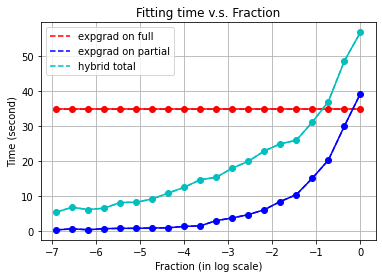

In [0]:
# Print Time and plot them
fr = np.log(fractions) 

import matplotlib.pyplot as plt

l1 = plt.plot(fr, time_expgrad_alls,'r--',label="expgrad on full")
#l2 = plt.plot(fr, time_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fr, time_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fr, time_hybrids,'c--',label="hybrid total")
plt.plot(fr, time_expgrad_alls,'ro-', #fr, time_grid_alls,'go-',
         fr, time_expgrad_fracs,'bo-', fr, time_hybrids,'co-')
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Time (second)')
plt.title('Fitting time v.s. Fraction')
plt.grid()
plt.legend()
plt.show()


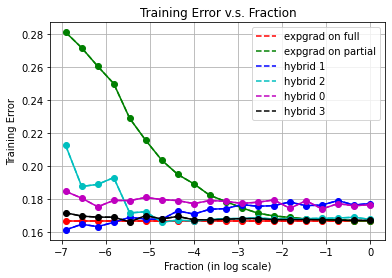

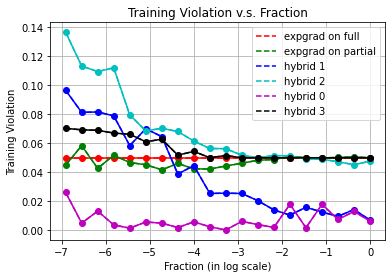

In [0]:

l1 = plt.plot(fr, error_expgrad_alls_train,'r--',label="expgrad on full")
l2 = plt.plot(fr, error_expgrad_fracs_train,'g--',label="expgrad on partial")
l3 = plt.plot(fr, error_hybrids_train,'b--',label="hybrid 1")
l4 = plt.plot(fr, error_grid_pmf_fracs_train,'c--',label="hybrid 2")
l5 = plt.plot(fr, error_best_lambdas_train,'m--',label="hybrid 0")
l6 = plt.plot(fr, error_rewts_pmf_train,'k--',label="hybrid 3")
plt.plot(fr, error_expgrad_alls_train,'ro-', fr, error_expgrad_fracs_train,'go-',
         fr, error_hybrids_train,'bo-', fr, error_grid_pmf_fracs_train,'co-',
         fr, error_best_lambdas_train,'mo-', fr, error_rewts_pmf_train,'ko-'
         )
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Training Error')
plt.title('Training Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fr, vio_expgrad_alls_train,'r--',label="expgrad on full")
l2 = plt.plot(fr, vio_expgrad_fracs_train,'g--',label="expgrad on partial")
l3 = plt.plot(fr, vio_hybrids_train,'b--',label="hybrid 1")
l4 = plt.plot(fr, vio_grid_pmf_fracs_train,'c--',label="hybrid 2")
l5 = plt.plot(fr, vio_best_lambdas_train,'m--',label="hybrid 0")
l6 = plt.plot(fr, vio_rewts_pmf_train,'k--',label="hybrid 3")
plt.plot(fr, vio_expgrad_alls_train,'ro-', fr, vio_expgrad_fracs_train,'go-',
         fr, vio_hybrids_train,'bo-', fr, vio_grid_pmf_fracs_train,'co-',
         fr, vio_best_lambdas_train,'mo-', fr, vio_rewts_pmf_train,'ko-'
         )
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Training Violation')
plt.title('Training Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

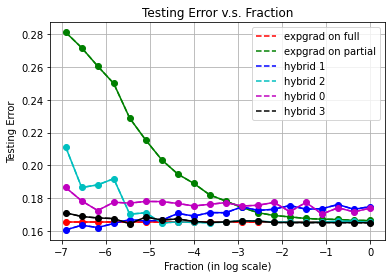

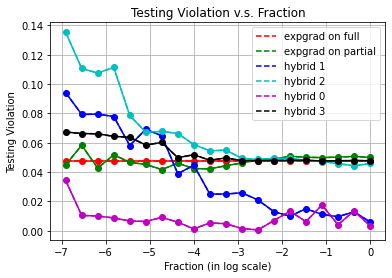

In [0]:
l1 = plt.plot(fr, error_expgrad_alls_test,'r--',label="expgrad on full")
l2 = plt.plot(fr, error_expgrad_fracs_test,'g--',label="expgrad on partial")
l3 = plt.plot(fr, error_hybrids_test,'b--',label="hybrid 1")
l4 = plt.plot(fr, error_grid_pmf_fracs_test,'c--',label="hybrid 2")
l5 = plt.plot(fr, error_best_lambdas_test,'m--',label="hybrid 0")
l6 = plt.plot(fr, error_rewts_pmf_test,'k--',label="hybrid 3")
plt.plot(fr, error_expgrad_alls_test,'ro-', fr, error_expgrad_fracs_test,'go-',
         fr, error_hybrids_test,'bo-', fr, error_grid_pmf_fracs_test,'co-',
         fr, error_best_lambdas_test,'mo-', fr, error_rewts_pmf_test,'ko-'
         )
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Testing Error')
plt.title('Testing Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fr, vio_expgrad_alls_test,'r--',label="expgrad on full")
l2 = plt.plot(fr, vio_expgrad_fracs_test,'g--',label="expgrad on partial")
l3 = plt.plot(fr, vio_hybrids_test,'b--',label="hybrid 1")
l4 = plt.plot(fr, vio_grid_pmf_fracs_test,'c--',label="hybrid 2")
l5 = plt.plot(fr, vio_best_lambdas_test,'m--',label="hybrid 0")
l6 = plt.plot(fr, vio_rewts_pmf_test,'k--',label="hybrid 3")
plt.plot(fr, vio_expgrad_alls_test,'ro-', fr, vio_expgrad_fracs_test,'go-',
         fr, vio_hybrids_test,'bo-', fr, vio_grid_pmf_fracs_test,'co-',
         fr, vio_best_lambdas_test,'mo-', fr, vio_rewts_pmf_test,'ko-'
         )
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Testing Violation')
plt.title('Testing Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()